In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math
import numpy as np
import statistics as stat
import scipy.stats as st

#### 1. Z obou datových souborů načtěte texty k analýze. Pro každý text zvlášť odhadněte základní charakteristiky délek slov, tj. střední hodnotu a rozptyl. Graficky znázorněte rozdělení délek slov. (1b)

In [2]:
# nacteni dat
def read_file(file):
    with open(file) as f:
        lines = f.readlines()
        return lines[1]

dpath = Path('../data')
first = read_file(dpath / 'first-009.txt')
second = read_file(dpath / 'second-005.txt')

In [3]:
first_word_len = [len(x) for x in first.split()]
second_word_len = [len(x) for x in second.split()]
dfa_word = pd.DataFrame({'slovo' :first.split(), 'delka':first_word_len})
dfb_word = pd.DataFrame({'slovo' :second.split(), 'delka':second_word_len})

print(f'Prvni soubor:')
print(f' - stredni hodnota: {stat.mean(dfa_word.delka)}')
print(f' - rozptyl: {stat.variance(dfa_word.delka)}') # np.var(dfa_word.delka, ddof=1)
 
print(f'\nDruhy soubor:')
print(f' - stredni hodnota: {stat.mean(dfb_word.delka)}')
print(f' - rozptyl: {stat.variance(dfb_word.delka)}')

Prvni soubor:
 - stredni hodnota: 4.2622641509433965
 - rozptyl: 4.990642649705133

Druhy soubor:
 - stredni hodnota: 4.010185185185185
 - rozptyl: 4.451240002746027


In [4]:
dfa_group = dfa_word.groupby(['delka']).count().reset_index()
dfa_group.columns = ['delka slova', 'pocet slov']
dfb_group = dfb_word.groupby(['delka']).count().reset_index()
dfb_group.columns = ['delka slova', 'pocet slov']
# display(dfa_group.head())
# display(dfb_group.head())

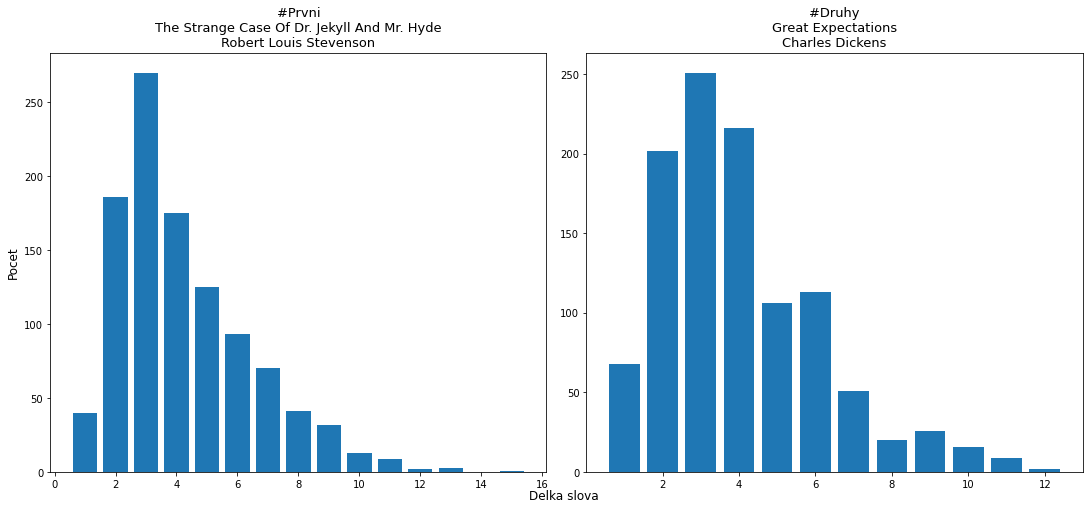

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs = axs.ravel()
axs[0].bar(dfa_group['delka slova'], dfa_group['pocet slov'])
axs[0].set_title('#Prvni\nThe Strange Case Of Dr. Jekyll And Mr. Hyde\nRobert Louis Stevenson', fontsize=13)
axs[1].bar(dfb_group['delka slova'], dfb_group['pocet slov'])
axs[1].set_title('#Druhy\nGreat Expectations\nCharles Dickens', fontsize=13)
fig.tight_layout()
axs[0].set_ylabel('Pocet', fontsize=12)
fig.text(0.51, 0.00, 'Delka slova', ha='center', fontsize=12);
#fig.suptitle('Rozdeleni delek slov', fontsize=15);

#### 2.  Pro každý text zvlášť odhadněte pravděpodobnosti písmen (symbolů mimo mezery), které se v textech vyskytují. Výsledné pravděpodobnosti graficky znázorněte. (1b)

In [6]:
# vypocitani cetnosti
def check_freq(x):
    freq = {}
    for c in set(x):
        if c != ' ':
            freq[c] = x.count(c)
    return freq

freq_first = check_freq(first)
freq_second = check_freq(second)

col = ['pismeno', 'absolutni cetnost']
dfa = pd.DataFrame(freq_first.items(), columns=col)
dfb = pd.DataFrame(freq_second.items(), columns=col)

def comp_rel_freq(*arg):
    for df in arg:
        df['pravdepodobnost'] = df['absolutni cetnost'] / df['absolutni cetnost'].sum()
        
comp_rel_freq(dfa, dfb)

dfa = dfa.sort_values('pismeno').reset_index(drop=True)
dfa = dfa.append([{'pismeno':'z', 'absolutni cetnost':0,'pravdepodobnost':0}])
dfb = dfb.sort_values('pismeno').reset_index(drop=True)

#display(dfa.head())
#display(dfb.head())

# kontrola pravdepodobnosti
assert dfa.pravdepodobnost.sum() == 1
assert dfb.pravdepodobnost.sum() == 1

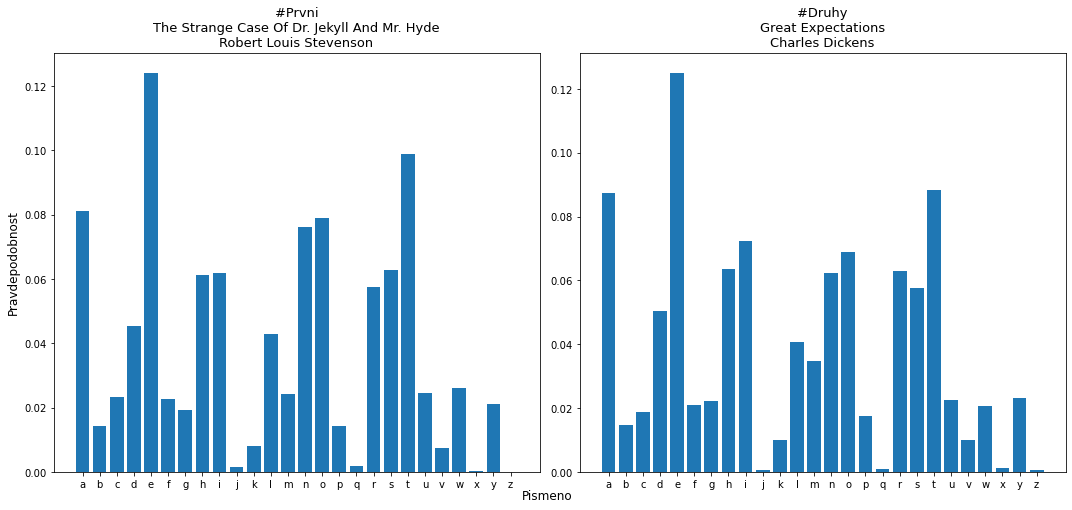

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs = axs.ravel()
axs[0].bar(dfa['pismeno'], dfa['pravdepodobnost'])
axs[0].set_title('#Prvni\nThe Strange Case Of Dr. Jekyll And Mr. Hyde\nRobert Louis Stevenson', fontsize=13)
axs[1].bar(dfb['pismeno'], dfb['pravdepodobnost'])
axs[1].set_title('#Druhy\nGreat Expectations\nCharles Dickens', fontsize=13)
axs[0].set_ylabel('Pravdepodobnost', fontsize=12)
fig.text(0.51, 0.00, 'Pismeno', ha='center', fontsize=12);
fig.tight_layout()

#### 3. Na hladině významnosti 5% otestujte hypotézu, že rozdělení délek slov nezávisí na tom, o který jde text. Určete také p-hodnotu testu. (1.5b)


**Budeme provádět test nezávislosti na základě kontingenčních tabulek**

Nejprve jsme si vytvořili kontingenční tabulku (matici), kde
* sloupce představovali jednotlivé délky slov vyskytujících se v textech
* řádky představovali jednotlivé texty
* jednotlivé hodnoty v tabulce představovali počet slov s danou délkou v daném textu

In [8]:
# hodnoty delek slov v jednotlivych textech
print(dfa_group["delka slova"].unique())
print(dfb_group["delka slova"].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 15]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [9]:
# pomoci setu sjednotime unikatni hodnoty, ktere nam budou tvorit hlavicky sloupcu v tabulce
text1_delka_slov = set(dfa_group["delka slova"].unique())
text2_delka_slov = set(dfb_group["delka slova"].unique())
columnNames = list(text1_delka_slov.union(text2_delka_slov))

In [10]:
# fkce k ziskani hodnot pro dany text
def getRowValues(df, cols):
    row = []
    for delka_slova in cols:
        relevant_row = df[df["delka slova"] == delka_slova]
        if len(relevant_row) == 0:
            row.append(0)
        elif len(relevant_row) == 1:
            row.append(relevant_row["pocet slov"].iloc[0])
        else:
            raise Exception("There seems to be > 1 rows for delka_slova = " + delka_slova)
    return row

In [11]:
# Nij - kontingencni tabulka
Nij = np.matrix([getRowValues(dfa_group, columnNames), getRowValues(dfb_group, columnNames)])
n = np.sum(Nij)
print("Nij =\n", Nij)
print("n =", n)

Nij =
 [[ 40 186 270 175 125  93  70  41  32  13   9   2   3   1]
 [ 68 202 251 216 106 113  51  20  26  16   9   2   0   0]]
n = 2140


Budeme testovat hypotézu $H_0: p_{ij} = p_{i•} p_{•j}$ proti alternativní hypotéze $H_A: p_{ij} \neq p_{i•} p_{•j}$, kde _i_ a _j_ jsou indexy v naší kontingenční tabulce.

Slovy: $H_0:$ Rozdělení délek slov nezávisí na tom, o který jde text $H_A:$ závisí

Potřebujeme si k tomu vypočítat marginální pravděpodobnosti.

Ty jsme vypočítali takto:
$p_{i•} = \sum_{j} p_{ij}$ a $p_{•j} = \sum_{i} p_{ij}$

In [12]:
# vraci marginálni pravdepodobnosti p_i• a p_•j pro kont. matici
def getMarginals(Nij):
    n = np.sum(Nij)
    p_ix = np.sum(Nij, axis = 1)/n
    p_xj = np.sum(Nij, axis = 0)/n
    return p_ix, p_xj

In [13]:
p_ix, p_xj = getMarginals(Nij)
print("p_i• = \n", p_ix)
print("p_•j = \n", p_xj)

p_i• = 
 [[0.4953271]
 [0.5046729]]
p_•j = 
 [[0.05046729 0.18130841 0.24345794 0.18271028 0.10794393 0.09626168
  0.05654206 0.02850467 0.0271028  0.0135514  0.00841121 0.00186916
  0.00140187 0.00046729]]


Dále jsem si vypočítali teoretické četnosti jednotlivých prvků tabulky

In [14]:
# teoretické četnosti
teor_cetnosti = n * np.matmul(p_ix,p_xj)
print("Teoretické četnosti =\n", teor_cetnosti)

Teoretické četnosti =
 [[ 53.4953271  192.18691589 258.06542056 193.6728972  114.42056075
  102.03738318  59.93457944  30.21495327  28.72897196  14.36448598
    8.91588785   1.98130841   1.48598131   0.4953271 ]
 [ 54.5046729  195.81308411 262.93457944 197.3271028  116.57943925
  103.96261682  61.06542056  30.78504673  29.27102804  14.63551402
    9.08411215   2.01869159   1.51401869   0.5046729 ]]


Jelikož teoretické četnosti by pro každý prvek měli být >= 5, spojili jsme sloupce s nejmenšími teor. četnostmi (vyšlo to na poslední 4 sloupce) do jednoho

In [15]:
# slouceni poslednich 4 sloupcu
last_4_cols_summed = np.sum(Nij[:,-4:], axis = 1)
Nij_edited = np.append(Nij[:, :-4], last_4_cols_summed, axis = 1)
# nove odhady marginál
p_ix, p_xj = getMarginals(Nij_edited)
# nove teoretické četnosti
teor_cetnosti = n * np.matmul(p_ix,p_xj)
print("Teoretické četnosti =\n", teor_cetnosti)

Teoretické četnosti =
 [[ 53.4953271  192.18691589 258.06542056 193.6728972  114.42056075
  102.03738318  59.93457944  30.21495327  28.72897196  14.36448598
   12.87850467]
 [ 54.5046729  195.81308411 262.93457944 197.3271028  116.57943925
  103.96261682  61.06542056  30.78504673  29.27102804  14.63551402
   13.12149533]]


Nyní máme již vše připraveno a stači pouze vypočítat hodnotu testové statistiky $\chi^2$ a tu následně porovnat s kritickým oborem. Oboje jsme vypočítali dle následující tabulky.
<img src="../img/kont_table.png" width="60%"/>
Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-12-Handout.pdf">courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-12-Handout.pdf</a>, sekce 10.8

In [16]:
# vypocet testove statistiky
N_ix = np.sum(Nij_edited, axis = 1)
N_xj = np.sum(Nij_edited, axis = 0)
Chi2 = np.sum(np.square(Nij_edited - (np.matmul(N_ix, N_xj)/n))/(np.matmul(N_ix, N_xj)/n))
# vypocet kriticke hodnoty
alpha = 0.05
row_cnt = np.size(Nij_edited,axis = 0)
col_cnt = np.size(Nij_edited, axis =1)
degrees_of_freedom = (row_cnt - 1) * (col_cnt - 1)
chi2 = st.chi2.isf(alpha, degrees_of_freedom) # hodnota byla pro jistotu zkontrolovana s hodnotou v tabulkach
print("Chi2 =", Chi2)
print("chi2 =", chi2)
print("Je Chi2 (testová statistika) >= chi2 (kriticka hodnota) ? ->", Chi2 >= chi2)

Chi2 = 27.990629509782508
chi2 = 18.30703805327515
Je Chi2 (testová statistika) >= chi2 (kriticka hodnota) ? -> True


**Hypotézu $H_0$ tedy zamítáme na 5 % hladině významnosti ve prospěch alternativní hypotézy $H_A$**

**Výpočet p-hodnoty**

In [17]:
# p-hodnota
p = st.chi2.sf(Chi2, degrees_of_freedom) # .sf by mela byt podle dokumentace presnejsi nez 1 - cdf
print("p =", p)
print("Pro kontrolu:", st.chi2.isf(p, degrees_of_freedom))

p = 0.0018114953578317325
Pro kontrolu: 27.990629509782508


#### 4.Na hladině významnosti 5% otestujte hypotézu, že se střední délky slov v obou textech rovnají. Určete také p-hodnotu testu. (1.5b)

Buďte $X_1, \ldots, X_n$ délky slov prvního textu a $Y_1, \ldots, Y_m$ délky slov druhého textu. Označmě $\mu_1$, $\mu_2$ střední délku slov prvního, resp. druhého textu.

Hypotézy sestavíme následovně:
* $H_0: \mu_1 = \mu_2$,
* $H_A: \mu_1 \neq \mu_2$.

U dvouvýběrového t-testu s normálními daty postupujeme:

* A. Použijeme Fisherův F-test pro zjištění rovnosti rozptylů, pokud data mají normální rozdělení. Jinak použijeme Levenův test.

* B. Provedeme dvouvýběrový t-test se znalostí o rovnosti rozptylů.

##### Test normálnosti dat
Pro test normálnosti $X$ a $Y$ použijeme [Shapirův test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html). Ten je přesnější než [normaltest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html).

In [18]:
# test normálnosti dat X
chi_kv, p = st.shapiro(dfa_word.delka)
print(f"testová statistika chi^2 = {chi_kv:0.3f}")
print(f"p-hodnota {p}")

testová statistika chi^2 = 0.904
p-hodnota 3.0366645878658866e-25


In [19]:
# test normálnosti dat Y
chi_kv, p = st.shapiro(dfb_word.delka)
print(f"testová statistika chi^2 = {chi_kv:0.3f}")
print(f"p-hodnota {p}")

testová statistika chi^2 = 0.908
p-hodnota 5.557396394346864e-25


Zamítáme, že $X$ a $Y$ patří do normálního rozdělení.

Podle CLV ale víme, že výběrový průměr délky slov konverguje k normálnímu rozdělení s rostoucím počtem dat. Dvouvýběrový t-test je tedy možné provést.

##### A1. Fisherův F-test shodnosti rozptylů
Pro zajímavost vyzkoušíme tento test rovnosti rozptylů, i když je náchylný na normalitu dat. Výsledky pak můžeme porovnat s Levenovým testem, který normalitu nepředpokládá.

Použijeme následující testovou statistiku a kritický obor pro $H_0: \sigma_1 = \sigma_2$.

<img src="../img/variance_f-test.png" width="60%"/>
Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-11-Handout.pdf">courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-11-Handout.pdf</a>, sekce 10.6

In [20]:
# Fisheruv F-test shodnosti rozptylu X_n a Y_m
muX = dfa_word.delka.mean()
muY = dfb_word.delka.mean()

n = len(dfa_word)
sX2 = dfa_word.delka.var(ddof=1)

m = len(dfb_word)
sY2 = dfb_word.delka.var(ddof=1)

alpha = 0.05
F = sX2 / sY2
f1 = st.f.isf(1-alpha/2, n-1, m-1)
f2 = st.f.isf(alpha/2, n-1, m-1)
pval = 2*st.f.sf(F, n-1, m-1)

print(f"Testová statistika: {F:0.3f}")
print(f"Kritická hodnota: f1 = {f1:.3f}")
print(f"Kritická hodnota: f2 = {f2:.3f}")
print(f"Zamítáme: {F <= f1 or F >= f2}")
print(f"p-hodnota: {pval:0.3f}")

Testová statistika: 1.121
Kritická hodnota: f1 = 0.887
Kritická hodnota: f2 = 1.127
Zamítáme: False
p-hodnota: 0.062


Podle Fisherova F-testu nezamítáme hypotézu o shodnosti rozptylů.

##### A2. Levenův test shodnosti rozptylů

In [21]:
stat, pval = st.levene(dfa_word.delka, dfb_word.delka)
print(f"p-hodnota: {pval:0.3f}")

p-hodnota: 0.107


Ani podle Levenova testu nezamítáme hypotézu o shodnosti rozptylů. Zde je vidět, že Levenův test je pro naše data mírnější. Hypotézu o shodnosti rozptylů by zamítl pro hladiny významnosti $\alpha >0.1$. F-test zamítá pro $\alpha >0.06$.

Uvažujme tedy **stejné** rozptyly.

##### B. Dvouvýběrový t-test – stejné rozptyly
Použijeme následující testovou statistiku a kritický obor pro $\mu_1 = \mu_2$.

<img src="../img/dvouvyberovy_t-test_stejne_rozptyly.png" width="60%"/>
Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-11-Handout.pdf">courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-11-Handout.pdf</a>, sekce 10.6

In [22]:
# T-test se stejnými rozptyly
alpha = 0.05

s12 = np.sqrt(((n-1)*sX2 + (m-1)*sY2)/(n+m-2))
T = (muX - muY)/s12*np.sqrt(n*m/(n+m))

print(f"Hodnota testové statistiky: T = {T:0.3f}")

krit = st.t.isf(alpha/2, df = n+m-2)
print(f"Kritická hodnota: t = {krit:0.3f}")

# výsledek testu
print(f"Zamítáme: {np.abs(T) >= krit}")

# p-hodnota
p_value = 2*st.t.sf(np.abs(T), df = n + m -2)
print(f"p-hodnota: {p_value:0.3f}")

Hodnota testové statistiky: T = 2.684
Kritická hodnota: t = 1.961
Zamítáme: True
p-hodnota: 0.007


#####  **Výsledek**
Na hladině významnosti 5% zamítáme hypotézu, že se střední délky slov v obou textech rovnají. Určená p-hodnota testu je 0.007. Zamítnutí je tedy velmi silné.

#### 5. Na hladině významnosti 5% otestujte hypotézu, že rozdělení písmen nezávisí na tom, o který jde text. Určete také p-hodnotu testu. (1b)

Postup volime stejny jako v bode 3. 

- Budeme provádět test nezávislosti na základě kontingenční tabulky *Nij* (sloupce = jednotliva pismena, radky = texty, hodnoty v tabulce = pocet vyskytu daneho pismena v danem textu)
 

In [23]:
# Nij = kontingencni tabulka
Nij = np.matrix([list(dfa['absolutni cetnost']), list(dfb['absolutni cetnost'])])
n = np.sum(Nij)
print("Nij =\n", Nij)
print("\nn =", n)

Nij =
 [[366  65 105 205 561 102  87 276 279   7  37 194 109 344 357  65   8 260
  284 447 111  34 118   2  95   0]
 [378  64  82 218 542  91  97 275 314   3  44 177 151 270 298  76   4 273
  249 383  98  44  90   6 101   3]]

n = 8849


- Dale budeme testovat hypotézu $H_0: p_{ij} = p_{i•} p_{•j}$ (rozdělení pismen **nezávisí** na tom, o který jde text) proti alternativní hypotéze $H_A: p_{ij} \neq p_{i•} p_{•j}$ (rozdělení pismen **závisí** ...), kde _i_ a _j_ jsou indexy v *Nij*.
Proto spocitame marginální pravděpodobnosti a teoretické četnosti jednotlivých prvků tabulky.

In [24]:
p_ix, p_xj = getMarginals(Nij)
print("p_i• = \n", p_ix)
print("p_•j = \n", p_xj)

teor_cetnosti = n * np.matmul(p_ix,p_xj)
print("\nTeoretické četnosti =\n", teor_cetnosti)

p_i• = 
 [[0.51056617]
 [0.48943383]]
p_•j = 
 [[0.0840773  0.01457792 0.02113233 0.04780201 0.12464685 0.02181037
  0.02079331 0.06226692 0.06701322 0.00113007 0.00915358 0.04192564
  0.02938185 0.06938637 0.07401966 0.015934   0.00135609 0.06023279
  0.06023279 0.09379591 0.02361849 0.00881456 0.02350548 0.00090406
  0.0221494  0.00033902]]

Teoretické četnosti =
 [[379.86122726  65.86303537  95.47587298 215.96948808 563.15448073
   98.53926997  93.94417448 281.32195728 302.76573624   5.10566166
   41.35585942 189.42004746 132.74720307 313.48762572 334.42083851
   71.98982936   6.12679399 272.1317663  272.1317663  423.7699175
  106.70832862  39.82416092 106.19776246   4.08452933 100.07096847
    1.5316985 ]
 [364.13877274  63.13696463  91.52412702 207.03051192 539.84551927
   94.46073003  90.05582552 269.67804272 290.23426376   4.89433834
   39.64414058 181.57995254 127.25279693 300.51237428 320.57916149
   69.01017064   5.87320601 260.8682337  260.8682337  406.2300825
  102.29167138

- Jelikož teoretické četnosti by pro každý prvek měli být >= 5, spojime sloupce s nejmenšími teoretickymi četnostmi (celkem 3 - pro pismena j, x a z) do jednoho

In [25]:
cols_sum = np.sum(Nij[:,[9,-3,-1]], axis = 1)

Nij_new = np.delete(Nij, 9, 1)
Nij_new = np.delete(Nij_new, -3, 1)
Nij_new = np.delete(Nij_new, -1, 1)
Nij_new = np.append(Nij_new, cols_sum, axis = 1)

p_ix, p_xj = getMarginals(Nij_new)

teor_cetnosti = n * np.matmul(p_ix,p_xj)
print("Teoretické četnosti =\n", teor_cetnosti)

Teoretické četnosti =
 [[379.86122726  65.86303537  95.47587298 215.96948808 563.15448073
   98.53926997  93.94417448 281.32195728 302.76573624  41.35585942
  189.42004746 132.74720307 313.48762572 334.42083851  71.98982936
    6.12679399 272.1317663  272.1317663  423.7699175  106.70832862
   39.82416092 106.19776246 100.07096847  10.72188948]
 [364.13877274  63.13696463  91.52412702 207.03051192 539.84551927
   94.46073003  90.05582552 269.67804272 290.23426376  39.64414058
  181.57995254 127.25279693 300.51237428 320.57916149  69.01017064
    5.87320601 260.8682337  260.8682337  406.2300825  102.29167138
   38.17583908 101.80223754  95.92903153  10.27811052]]


- Teoreticke cetnosti nyni sedi a mame vse pripraveno. Spocitame hodnotu testové statistiky  𝜒2 a porovname s kritickým oborem (spocitame podle tabulky v bode 3)

In [26]:
N_ix = np.sum(Nij_new, axis = 1)
N_xj = np.sum(Nij_new, axis = 0)
Chi2 = np.sum(np.square(Nij_new - (np.matmul(N_ix, N_xj)/n))/(np.matmul(N_ix, N_xj)/n))

alpha = 0.05
row_cnt = np.size(Nij_new, axis = 0)
col_cnt = np.size(Nij_new, axis = 1)
degrees_of_freedom = (row_cnt - 1) * (col_cnt - 1)
chi2 = st.chi2.isf(alpha, degrees_of_freedom) # hodnota byla pro jistotu zkontrolovana s hodnotou v tabulkach
print("Chi2 =", Chi2)
print("chi2 =", chi2)
print("Je Chi2 (testová statistika) >= chi2 (kriticka hodnota)?", Chi2 >= chi2)

print("\np-value =", st.chi2.sf(Chi2, degrees_of_freedom))

Chi2 = 41.6774164266332
chi2 = 35.17246162690807
Je Chi2 (testová statistika) >= chi2 (kriticka hodnota)? True

p-value = 0.009896528037422862


**Hypotézu $H_0$ zamítáme na 5 % hladině významnosti ve prospěch alternativní hypotézy $H_A$. Rozdeleni pismen zavisi na textu.**